## Initial Setup

You need to have the dea_bom.py file accessable. It should be located in the Scripts file. 

In [1]:
%matplotlib inline
from IPython.display import display
import matplotlib.pyplot as plt
import sys
sys.path.append('../Scripts')
import os
import pickle
from pathlib import Path
import dea_bom
import pandas as pd
import numpy as np
import xarray as xr
import datacube
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
import warnings
warnings.filterwarnings('ignore', module='datacube')
%load_ext autoreload
%autoreload 2

## List of All Available Stations

This part of the code accesses the dea_bom.py module which contains an XML webscraping code. It retrieves the stream gauges from BOM's Water Data Online website.

In [2]:
%%time
stations_pkl = Path('stations.pkl')

# if cache exists, get it from cache
if stations_pkl.exists():
    print('Loading from cache')
    stations = pickle.load(open(str(stations_pkl), 'rb'))
else:
    print('Fetching from BoM')
    stations = dea_bom.get_stations()
    pickle.dump(stations, open(str(stations_pkl), 'wb'))
    
len(stations), stations[:5]

Loading from cache
CPU times: user 9.6 ms, sys: 4.43 ms, total: 14 ms
Wall time: 13.8 ms


(6027,
 [namespace(name='15 MILE @ GRETA STH', pos=(-36.61945775, 146.24407214), url='http://bom.gov.au/waterdata/services/stations/403213'),
  namespace(name='15 MILE @ WANGARATTA', pos=(-36.36666667, 146.2833333), url='http://bom.gov.au/waterdata/services/stations/403239'),
  namespace(name='15 MILE CK GLENROWAN', pos=(-36.47080718, 146.246199), url='http://bom.gov.au/waterdata/services/stations/403251'),
  namespace(name='16 Mile Waterhole', pos=(-18.876921, 139.360487), url='http://bom.gov.au/waterdata/services/stations/913010A'),
  namespace(name='163 Clifton Rd', pos=(-32.97808, 115.90111), url='http://bom.gov.au/waterdata/services/stations/6131318')])

## Plot a map of stations and select a gauge that contains data

For the demonstration we have limited gauges to those in the basin area for faster loading, however there are gauges all over Australia. Choose a gauge on the map. When you have the station you want, click Done then run the rest of the code. If you want to make another selection after Done has been clicked, you will have to re-run this box with Shift + Enter. 

In [5]:
gauge_data, station = dea_bom.ui_select_station(stations);

## Generate a flow duration curve from the data selected above
The code will automatically select the latitude and longitude of the selected gauge. The buffer, which is the radius around the location point, is set to 8000 meters but you can change it if you like. Keep in mind that a bigger buffer will take longer to load. 

You have selected: lat = -34.5767
You have selected: lon = 142.7675


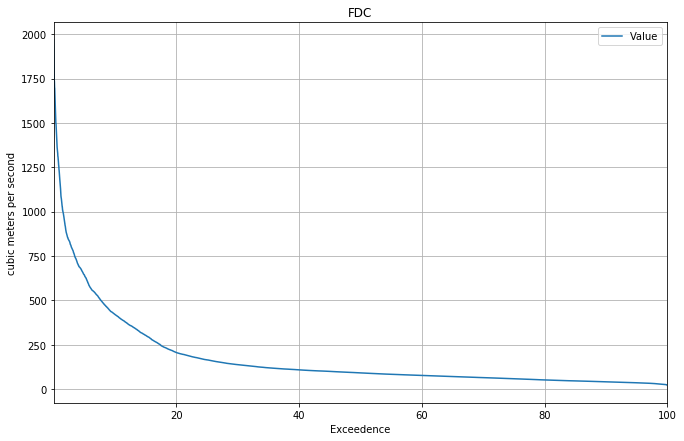

In [14]:
pos = station.pos

#The lat and lon takes the location of the gauge. You can change the lat and lon to a different location if necessary, 
#just hashtag out the lat, lon = pos line below and define your own.
lat, lon = pos

#lat = 
#lon = 

#The buffer is how many meters radius around the location you want to display.
buffer = 8000 

#Rearranging data into a flow duration curve
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100

#Plotting the flow duration curve
gauge_data.plot(x='Exceedence', y='Value', figsize=(11,7))
plt.ylabel('cubic meters per second')
plt.grid(True)
plt.title('FDC')

print("You have selected: lat = {}".format(lat))
print("You have selected: lon = {}".format(lon))

Now you can enter the flow parameters you are interested in mapping for. Choose values on the y-axis and enter them in the box below. The output will tell you how many times there was a satellite pass while the gauge was reading between those values. This is important to know because if you get more then 300 passes, it could take longer than expected to load the image and if you only get around 5 passes, this won't be enough to generate a reliable image. I suggest aiming for between 50 and 300 passes. The output of this box will also display the selected parameters on a log scale. 

(I suggest loading under 300 passes)


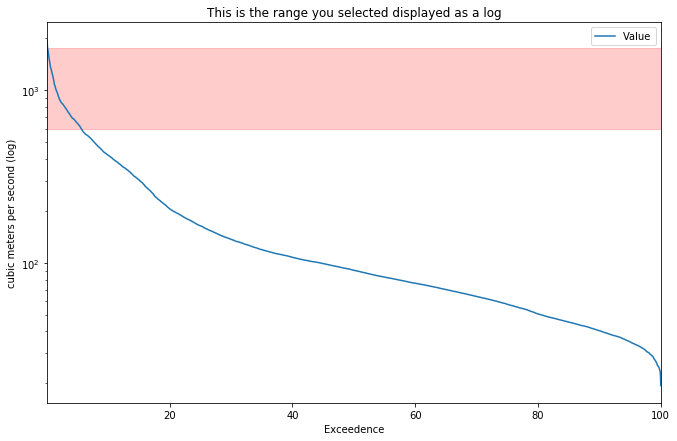

In [15]:
#What part of the Flow Duration Curve do you want to look at?
yaxis_lower_parameter = 600
yaxis_higher_parameter = 1750

#Let's look at it on a log scale
ax2 = gauge_data.plot(x='Exceedence', y='Value', figsize=(11,7)) 
ax2 = plt.axhspan(yaxis_lower_parameter, yaxis_higher_parameter, color='red', alpha=0.2)
ax2 = plt.title('This is the range you selected displayed as a log')
ax2 = plt.ylabel('cubic meters per second (log)')
ax2 = plt.xlabel('Exceedence')
ax2 = plt.yscale('log')

gauge_data_xr = gauge_data.to_xarray()

#Dask loading wofs_albers data (loading parameters only, not loading the actual satellite data since 1988)
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('1988-01-01', '2019-08-22'), # You might want to change the date to todays date
         'crs': 'EPSG:3577'} 
dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', **query)

# Merging satellite data with gauge data by timestamp
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time)

# Here is where it takes into account user input for the FDC
specified_level = merged_data.where((merged_data.Value > yaxis_lower_parameter) & 
                                    (merged_data.Value < yaxis_higher_parameter), drop=True)
date_list = specified_level.time.values

print("WARNING: You are about to load this many satellite passes: {}".format(specified_level.time.shape[0]))
print("(I suggest loading under 300 passes)")

The box below will cloud mask the images, meaning it will take out images that had too much cloud to see anything. It will then generate a summary image made by layering the clear images on top of each other to show the frequency of water observed while the gauge was reading the specified flow values. Yellow means water was present in every pass during the specified flows and purple means it was only there once or twice. The output will also tell you how many clear passes were used to generate the image. I suggest having at least 12 passes for a reliable image. 

This image was made by layering this many images: 47


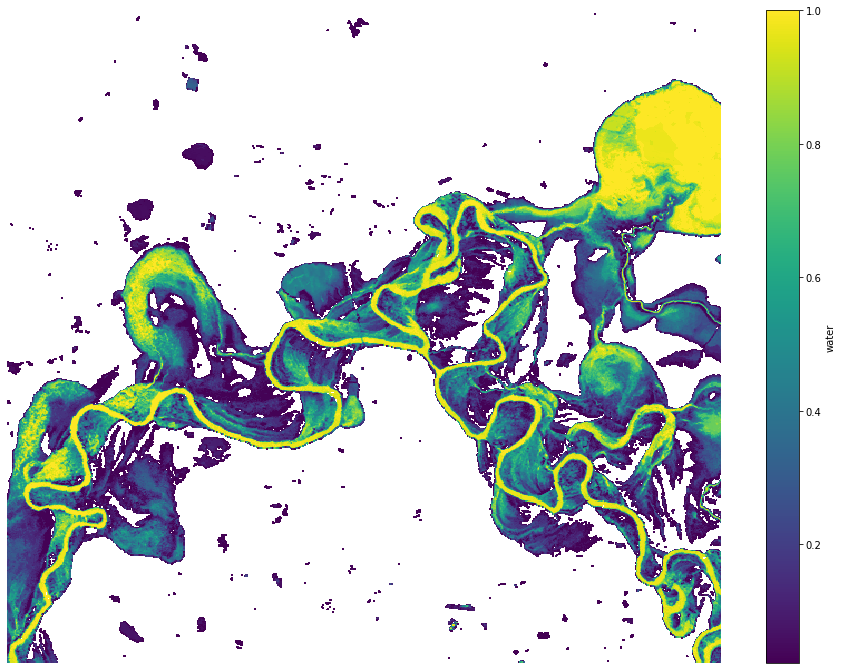

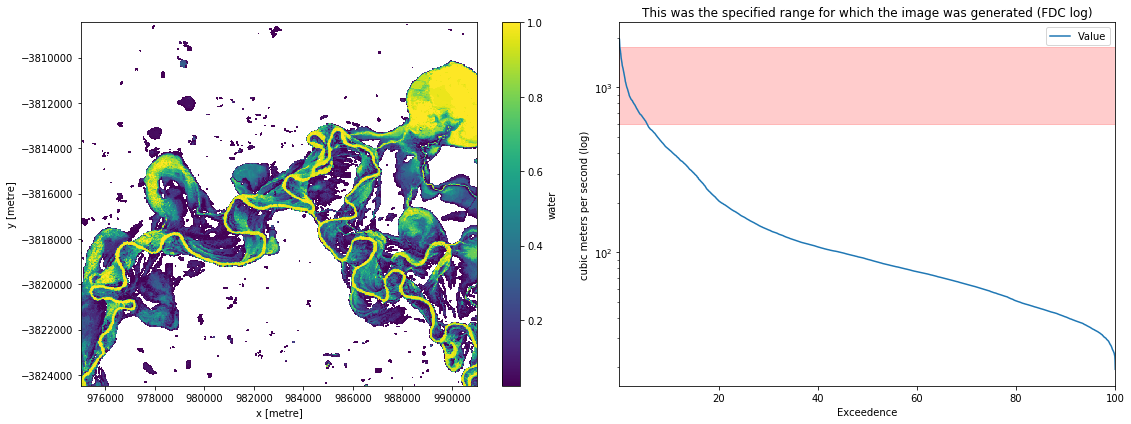

In [16]:
# load the passes that happened during the specified flow parameters
specified_passes = wofs_albers.sel(time=date_list).compute()

# prune out "too cloudy" passes
cc = masking.make_mask(specified_passes.water, cloud=True)

npixels_per_slice = specified_passes.water.shape[1]*specified_passes.water.shape[2]
npixels_per_slice

ncloud_pixels = cc.sum(dim='x').sum(dim='y')
cloud_pixels_fraction = (ncloud_pixels/npixels_per_slice)

clear_specified_passes = specified_passes.water.isel(time=cloud_pixels_fraction<0.5)
clear_specified_passes.shape

#Create parameters for the image
wet = (clear_specified_passes == 128).sum(dim='time')
dry = (clear_specified_passes == 0).sum(dim='time')
clear = wet + dry
frequency = wet / clear
frequency= frequency.fillna(0) #this is to get rid of the NAs that occur due to mountain shadows
frequency = frequency.where(frequency!=0) #This is to tell it to make areas that were dry 100% of the time white

#Plotting the image
frequency.plot(figsize = (16, 12))
plt.axis('off')

fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

ax1 = frequency.plot(ax=ax[0])

ax2 = gauge_data.plot(x='Exceedence', y='Value', ax=ax[1]) 
ax2 = plt.axhspan(yaxis_lower_parameter, yaxis_higher_parameter, color='red', alpha=0.2)
ax2 = plt.title('This was the specified range for which the image was generated (FDC log)')
ax2 = plt.ylabel('cubic meters per second (log)')
ax2 = plt.xlabel('Exceedence')
ax2 = plt.yscale('log')

plt.tight_layout()

print("This image was made by layering this many images: {}".format(clear_specified_passes.time.shape[0]))

Great, this is an image of the gauge location according to the flow values you selected. You can now go back and change the flow parameters or you can re-run the map box and choose a different gauge all together. Save the image by taking a screen shot of it.

--------------------------------------------------------------